# Society for Neuroscience Annual Meeting, 2022
# \#8587 Population spike-synchrony contributes to the spectral exponent of aperiodic neural activity
#### M. W. Preston, S. Fei, B. Voytek
## Poster Panel \#1: Correlated spiking activity is associated with a steepening of the field potential power spectrum

### Set-up

#### Imports

In [1]:
# general imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import TwoSlopeNorm, Normalize
from matplotlib.cm import ScalarMappable

In [2]:
# spike analysis toolboxes

# elephant
from elephant.conversion import BinnedSpikeTrain
from elephant.spike_train_correlation import correlation_coefficient, covariance

# elephant reqs
import neo
import quantities as pq


In [3]:
# voytek lab imports
from neurodsp.spectral import compute_spectrum
from neurodsp.utils import create_times


In [4]:
# project-specific imports
import sys
sys.path.append('C:/users/micha/projects/sfn_2022//scripts')
from utils import sim_ou_process, comp_exp, spiketimes_to_spiketrains, \
    spikes_to_lfp, get_spike_times, convolve_psps


#### Settings

In [5]:
# directories
PATH = "C:/Users/micha/projects/sfn_2022"
DIR_FIG = PATH + "/figures"
DIR_DATA = PATH + "/data"

In [6]:
# simulation settings
N_SECONDS = 10
FS = 1000 # sampling frequency
N_NEURONS = 1000
MEAN_RATE = 10 # average rate of each neuron (Hz)

# random process params
ALPHA = 1.
TAU_C = 25 / 1000

In [31]:
# figure appearance
plt.style.use(PATH + '/stylelib/sfn_2022.mplstyle')
COLORS = ["#7570b3", "#3FAA96", "#F39943"]

# figure size
FIG_WIDTH = 18
FIG_HEIGHT = 10

#### Functions

In [8]:
def sim_homogeneous_pool(rand_process=None, n_neurons=5, mu=20, variance=300, n_seconds=1, fs=1000,
                         tau_c=0.01):
    """
    *** modied to input white noise process or any random process ***
    
    simulate population spiking of N neurons firing at firing_rate each, return a
    spike trains roster of size (n_seconds*fs by n_neurons)

    Parameters
    ----------
    n_neurons : scalar, optional
        number of neurons in population. The default is 5.
    mu : scalar, optional
        mean of random walk. The default is 20.
    sigma : scalar, optional
        std of random walk. The default is 300.
    n_seconds : scalar, optional
        duration of signal (s). The default is 1.
    fs : scalar, optional
        sampling frequency (Hz). The default is 1000.
    tau : scalar, optional
        timescale (sec). The default is 0.01.

    Returns
    -------
    spikes : 2D array
        spike trains.
    rand_process : 1D array
        instantanious firing rate.

    """

    if rand_process is None:
        # simulate randon process (Ornstein-Uhlenbeck)
        rand_process, _ = sim_ou_process(n_seconds, fs, mu=mu, sigma=variance**0.5, tau=tau_c)
        # rand_process[rand_process < 0] = 0 # ensure all positive values

    # generate spikes from OU process
    spikes = np.zeros([n_neurons, len(rand_process)])

    # turn rates into spikes
    for j_bin in range(len(rand_process)):
        for i_neuron in range(n_neurons):
            if rand_process[j_bin] / fs > np.random.uniform():
                spikes[i_neuron, j_bin] = 1
    
    return spikes, rand_process

In [9]:
def run_homogeneouspool_sim(sync=True):
    # imports
    from scipy.signal import detrend

    # simulate spiking
    if sync:
        # simulate synchronized spiking
        spikes, rand_process = sim_homogeneous_pool(n_neurons=N_NEURONS, mu=MEAN_RATE, variance=MEAN_RATE**2, n_seconds=10, fs=FS, tau_c=TAU_C)
    
    else:
        # simulate desynchronized spiking
        rand_white = np.random.normal(loc=MEAN_RATE, scale=MEAN_RATE**0.5, size=N_SECONDS*FS)
        spikes, _ = sim_homogeneous_pool(rand_process=rand_white, n_neurons=N_NEURONS, n_seconds=N_SECONDS, fs=FS)

    # get spike times
    time = np.linspace(0,N_SECONDS,spikes.shape[1])
    spike_times = []
    for i_cell in range(len(spikes)):
        spike_times.append(get_spike_times(spikes[i_cell], time))

    # simulate LFP
    pop_spikes = np.sum(spikes, axis=0)
    lfp = convolve_psps(pop_spikes, FS)
    lfp = detrend(lfp, type='constant')
    freq, spectra = compute_spectrum(lfp, FS, f_range=[2,200])
    
    return spike_times, lfp, spectra, freq


### Main

In [10]:
# run sim
spike_times, lfp, spectra, freq = run_homogeneouspool_sim(sync=True)
spike_times_w, lfp_w, spectra_w, freq_w = run_homogeneouspool_sim(sync=False)


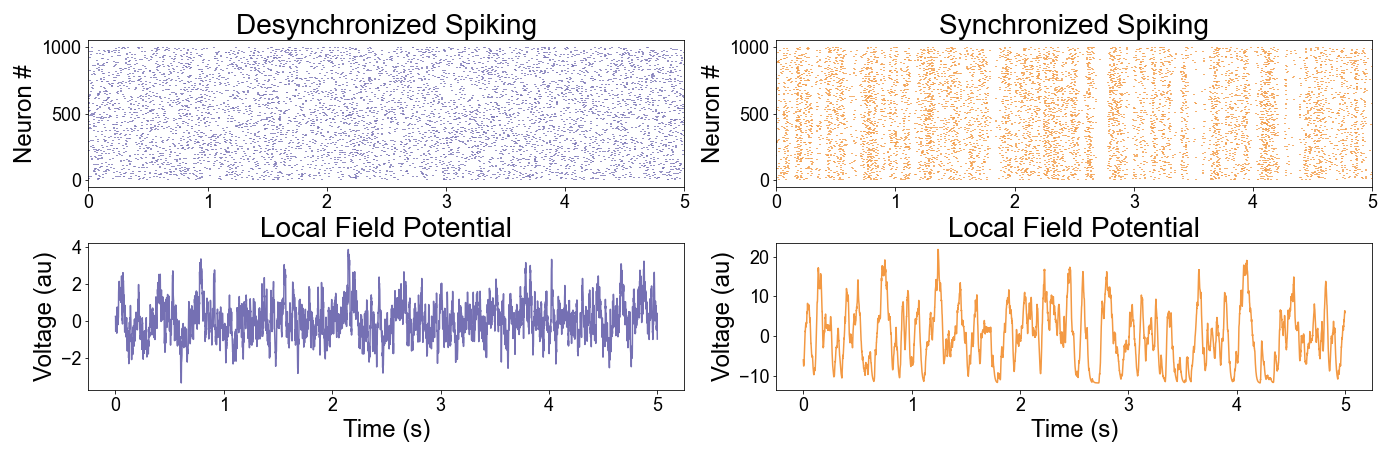

In [11]:
# plot spiking and LFP

# settings
time2plot = 5 # plot XXX seconds only

# create figure and axes
fig = plt.figure(figsize=[FIG_WIDTH,6])

# set up gridspec
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
ax00 = fig.add_subplot(spec[0,0])
ax10 = fig.add_subplot(spec[1,0])
ax01 = fig.add_subplot(spec[0,1])
ax11 = fig.add_subplot(spec[1,1])

# plot spiking
ax00.eventplot(spike_times_w, color=COLORS[0])
ax01.eventplot(spike_times, color=COLORS[2])
for ax in[ax00, ax01]:
    ax.set_xlim([0, time2plot])
    
# plot LFPs
t_lfp = create_times(time2plot, FS)
ax10.plot(t_lfp, lfp_w[:time2plot*FS], color=COLORS[0])
ax11.plot(t_lfp, lfp[:time2plot*FS], color=COLORS[2])

# labels
for ax in[ax10, ax11]:
    ax.set(xlabel='Time (s)')
    ax.set(ylabel='Voltage (au)')
for ax in[ax00, ax01]:
    ax.set(ylabel='Neuron #')

# set titles
ax00.set_title('Desynchronized Spiking')
ax10.set_title('Local Field Potential')
ax01.set_title('Synchronized Spiking')
ax11.set_title('Local Field Potential')

# save
plt.savefig(DIR_FIG + '/panel_1_fig1.png')

c:\Users\micha\anaconda3\envs\sfn_2022\lib\site-packages\elephant\conversion.py:1171: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  "input spiketrain".format(n_discarded))
c:\Users\micha\anaconda3\envs\sfn_2022\lib\site-packages\elephant\conversion.py:1171: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  "input spiketrain".format(n_discarded))


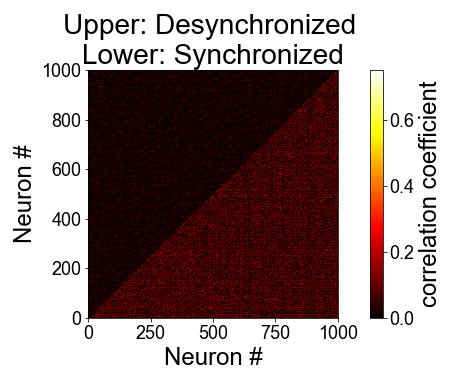

In [12]:
# compute correlation/covarience measures

corr_mat = np.zeros([2,N_NEURONS,N_NEURONS])
cov_mat = np.zeros([2,N_NEURONS,N_NEURONS])
corr_mu = np.zeros(2)
cov_mu = np.zeros(2)

for ii, st in enumerate([spike_times_w,spike_times]):
    n_units = len(st)
    spike_trains = []
    for i_unit in range(n_units):
        st_i = neo.SpikeTrain(st[i_unit]*pq.s, N_SECONDS*pq.s)
        spike_trains.append(st_i)

    # compute corr
    cov_mat[ii] = covariance(BinnedSpikeTrain(spike_trains, bin_size=10*pq.ms))
    cov_mu[ii] = np.mean(cov_mat[ii])
    corr_mat[ii] = correlation_coefficient(BinnedSpikeTrain(spike_trains, bin_size=10*pq.ms))
    corr_mu[ii] = np.mean(corr_mat[ii])

# combine data for compact plotting
corr_mat_comb = np.tril(corr_mat[0], -1) + np.triu(corr_mat[1], 1)

# compute norm for colorbar
norm = Normalize(vmin=0, vmax=np.max(corr_mat)*0.75)

fig, ax = plt.subplots(figsize=[6,5])
ax.pcolormesh(corr_mat_comb, cmap='hot', norm=norm)
fig.colorbar(ScalarMappable(norm=norm, cmap='hot'), ax=ax, label='correlation coefficient')
ax.set(xlabel='Neuron #',ylabel='Neuron #')
ax.set_title('Upper: Desynchronized \nLower: Synchronized')

# save
plt.savefig(DIR_FIG + '/panel_1_fig2.png')

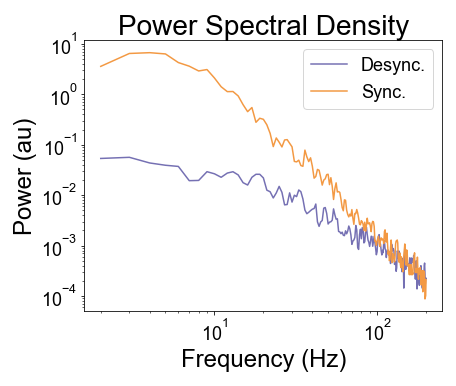

In [13]:
# Plot spectra

# plot
fig, ax_psd = plt.subplots(figsize=[6,5])
ax_psd.loglog(freq_w, spectra_w, label='Desync.', color=COLORS[0])
ax_psd.loglog(freq, spectra, label='Sync.', color=COLORS[2])
ax_psd.legend()

# label
ax_psd.set(xlabel='Frequency (Hz)', ylabel='Power (au)')
ax_psd.set_title('Power Spectral Density')

# save
plt.savefig(DIR_FIG + '/panel_1_fig3.png')

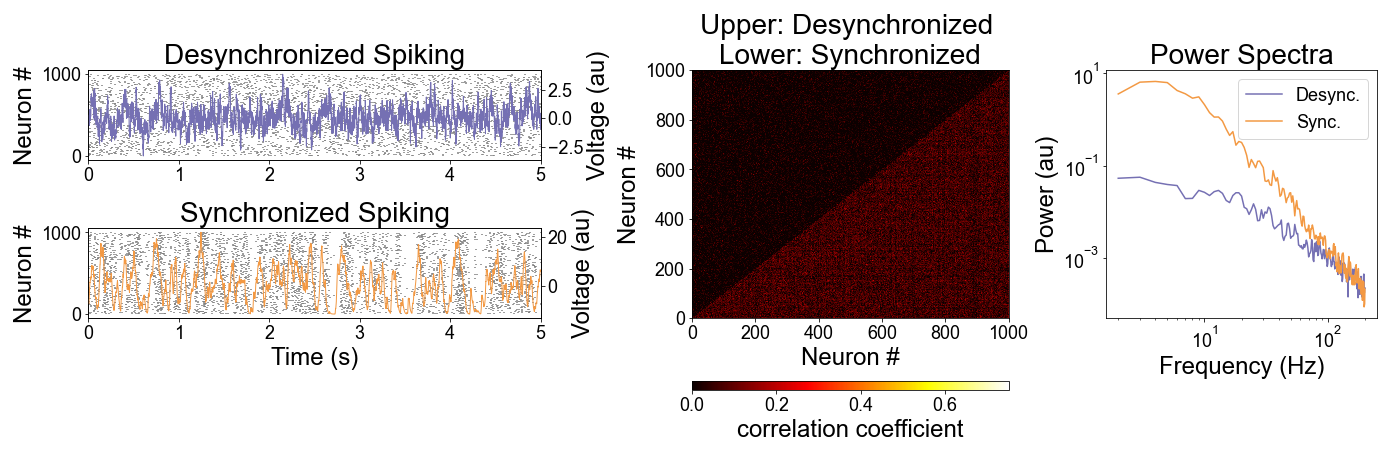

In [14]:
# create figure

# settings
time2plot = 5 # plot XXX seconds only

# create figure and axes
fig = plt.figure(figsize=[FIG_WIDTH,6])

# set up gridspec
spec = gridspec.GridSpec(ncols=3, nrows=3, figure=fig, 
    width_ratios=[2,1.4,1.2], height_ratios=[1,1,0.1])
ax00 = fig.add_subplot(spec[0,0])
ax01 = fig.add_subplot(spec[1,0])
ax_corr = fig.add_subplot(spec[:2,1])
ax_psd = fig.add_subplot(spec[:2,2])
ax_cb = fig.add_subplot(spec[2,1])

# plot spikes and lfp
cols= [COLORS[0], COLORS[2]]
for ii, (ax, pop_spikes, field) in enumerate(zip([ax00,ax01], [spike_times_w, spike_times], [lfp_w, lfp])):
    # plot spikes
    ax.eventplot(pop_spikes, color='grey')
    ax.set(ylabel='Neuron #')
    ax.set_xlim([0,time2plot])
    # plot LFP
    field = field[:time2plot*FS]
    axr = ax.twinx() 
    axr.plot(t_lfp[:len(field)], field, linewidth=1, color=cols[ii])
    axr.set(ylabel='Voltage (au)')
ax01.set(xlabel='Time (s)', ylabel='Neuron #')

# plot corr
ax_corr.pcolormesh(corr_mat_comb, cmap='hot', norm=norm)
fig.colorbar(ScalarMappable(norm=norm, cmap='hot'), ax=ax_corr, cax=ax_cb,
    orientation='horizontal', label='correlation coefficient')
ax_corr.set(xlabel='Neuron #',ylabel='Neuron #')
ax_corr.set_title('Upper: Desynchronized \nLower: Synchronized')

# plt PDSs
ax_psd.loglog(freq_w, spectra_w, label='Desync.', color=COLORS[0])
ax_psd.loglog(freq, spectra, label='Sync.', color=COLORS[2])
ax_psd.legend()

# labels
ax_psd.set(xlabel='Frequency (Hz)', ylabel='Power (au)')
for ax in[ax10, ax11]:
    ax.set(xlabel='Time (s)')
    ax.set(ylabel='Voltage (au)')
for ax in[ax00, ax01]:
    ax.set(ylabel='Neuron #')

# set titles
ax00.set_title('Desynchronized Spiking')
ax10.set_title('Local Field Potential')
ax01.set_title('Synchronized Spiking')
ax11.set_title('Local Field Potential')
ax_psd.set_title('Power Spectra')

# save
plt.savefig(DIR_FIG + '/panel_1_fig4.png')

### Repeat simulation for for N iterations

In [15]:
# settings
N_ITER = 100
N_NEURONS = 100 # re-setting this here to reduce computational time


In [16]:
# # Run simulation - N iteration
# # init
# _, temp_0, temp_1, _ = run_homogeneouspool_sim(sync=False)
# lfp = np.zeros([N_ITER, len(temp_0)])
# lfp_w = np.zeros([N_ITER, len(temp_0)])
# spectra = np.zeros([N_ITER, len(temp_1)])
# spectra_w = np.zeros([N_ITER, len(temp_1)])

# # run sim
# for ii in range(N_ITER):
#     print(ii)
#     _, lfp[ii], spectra[ii], freq = run_homogeneouspool_sim(sync=True)
#     _, lfp_w[ii], spectra_w[ii], freq_w = run_homogeneouspool_sim(sync=False)

# # comp exp
# exp = comp_exp(lfp, FS)
# exp_w = comp_exp(lfp_w, FS)


In [17]:
# load/save data
 
# save data
# np.savez(PATH+'/data/panel_1_exponents', exp=exp, exp_w=exp_w)

# load data
data_in = np.load(PATH+'/data/panel_1_exponents.npz')
exp = data_in['exp']
exp_w = data_in['exp_w']


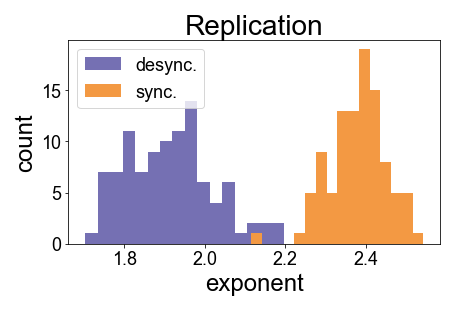

In [18]:
# plot replication results
fig, ax = plt.subplots()
ax.hist(exp_w, 16, color=COLORS[0], label='desync.')
ax.hist(exp, 16, color=COLORS[2], label='sync.')
ax.set(xlabel='exponent', ylabel='count')
ax.set_title('Replication')
ax.legend()

In [19]:
# siulate once more for plotting example

# run sim
spike_times, lfp, spectra, freq = run_homogeneouspool_sim(sync=True)
spike_times_w, lfp_w, spectra_w, freq_w = run_homogeneouspool_sim(sync=False)

# compute correlation/covarience measures
corr_mat = np.zeros([2,N_NEURONS,N_NEURONS])
cov_mat = np.zeros([2,N_NEURONS,N_NEURONS])
corr_mu = np.zeros(2)
cov_mu = np.zeros(2)

for ii, st in enumerate([spike_times_w,spike_times]):
    n_units = len(st)
    spike_trains = []
    for i_unit in range(n_units):
        st_i = neo.SpikeTrain(st[i_unit]*pq.s, N_SECONDS*pq.s)
        spike_trains.append(st_i)

    # compute corr
    cov_mat[ii] = covariance(BinnedSpikeTrain(spike_trains, bin_size=10*pq.ms))
    cov_mu[ii] = np.mean(cov_mat[ii])
    corr_mat[ii] = correlation_coefficient(BinnedSpikeTrain(spike_trains, bin_size=10*pq.ms))
    corr_mu[ii] = np.mean(corr_mat[ii])

# combine data for compact plotting
corr_mat_comb = np.tril(corr_mat[0], -1) + np.triu(corr_mat[1], 1)

# compute norm for colorbar
norm = Normalize(vmin=0, vmax=np.max(corr_mat_comb)*0.5)


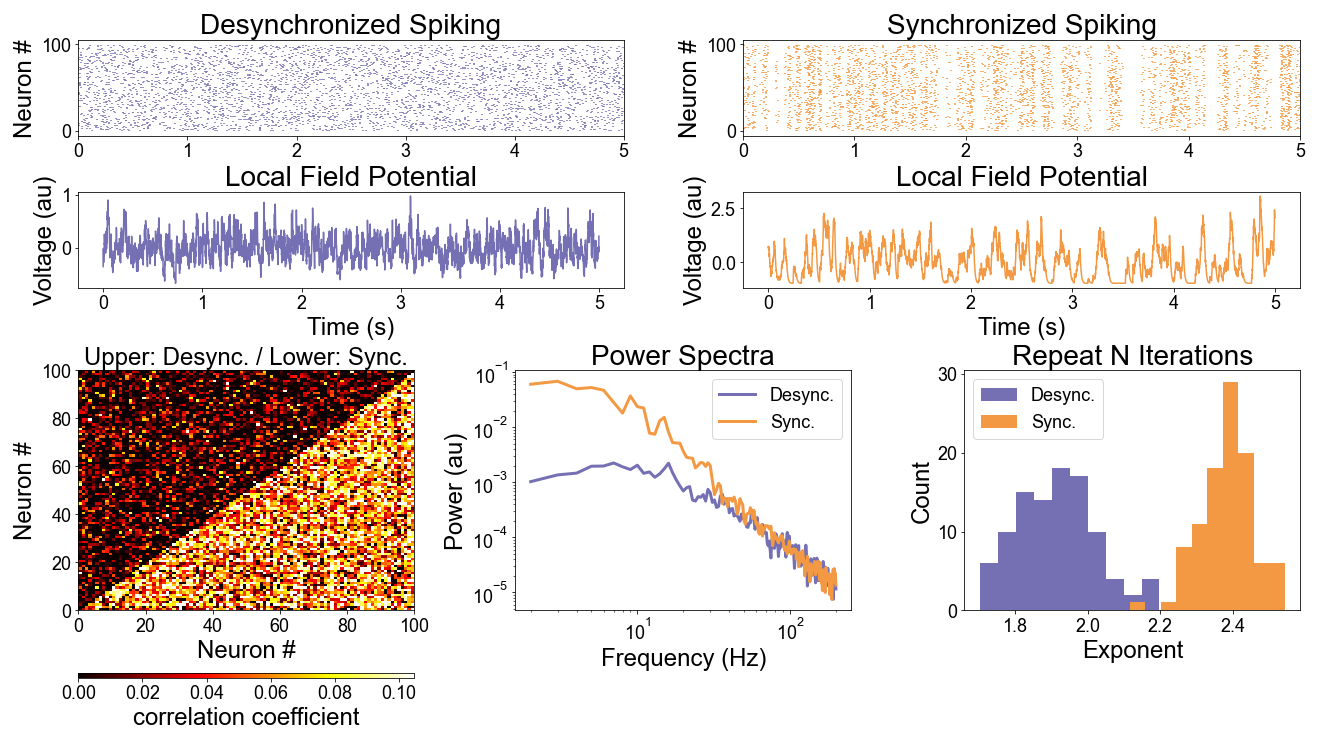

In [33]:
# plot all

# settings
time2plot = 5 # plot XXX seconds only

# create figure and axes
fig = plt.figure(figsize=[FIG_WIDTH,FIG_HEIGHT])

# set up gridspec
spec = gridspec.GridSpec(ncols=6, nrows=4, figure=fig, height_ratios=[1,1,2.5,0.05])
ax00 = fig.add_subplot(spec[0,:3])
ax10 = fig.add_subplot(spec[1,:3])
ax01 = fig.add_subplot(spec[0,3:])
ax11 = fig.add_subplot(spec[1,3:])
ax20 = fig.add_subplot(spec[2,:2])
ax21 = fig.add_subplot(spec[2,2:4])
ax22 = fig.add_subplot(spec[2,4:])
axcb = fig.add_subplot(spec[3,:2])

# plot spiking
ax00.eventplot(spike_times_w, color=COLORS[0])
ax01.eventplot(spike_times, color=COLORS[2])
for ax in[ax00, ax01]:
    ax.set_xlim([0, time2plot])
    
# plot LFPs
t_lfp = create_times(time2plot, FS)
ax10.plot(t_lfp, lfp_w[:time2plot*FS], color=COLORS[0])
ax11.plot(t_lfp, lfp[:time2plot*FS], color=COLORS[2])

# labels
for ax in[ax10, ax11]:
    ax.set(xlabel='Time (s)')
    ax.set(ylabel='Voltage (au)')
for ax in[ax00, ax01]:
    ax.set(ylabel='Neuron #')

# set titles
ax00.set_title('Desynchronized Spiking')
ax10.set_title('Local Field Potential')
ax01.set_title('Synchronized Spiking')
ax11.set_title('Local Field Potential')
ax20.set_title('Upper: Desync. / Lower: Sync.', fontsize=24)
ax21.set_title('Power Spectra')
ax22.set_title('Repeat N Iterations')

# ------- lower plots -------
# plot corr
ax20.pcolormesh(corr_mat_comb, cmap='hot', norm=norm)

fig.colorbar(ScalarMappable(norm=norm, cmap='hot'), ax=20, cax=axcb,
    orientation='horizontal', label='correlation coefficient')
ax20.set(xlabel='Neuron #',ylabel='Neuron #')

# plt PDSs
ax21.loglog(freq_w, spectra_w, label='Desync.', linewidth=3, color=COLORS[0])
ax21.loglog(freq, spectra, label='Sync.', linewidth=3, color=COLORS[2])
ax21.set(xlabel='Frequency (Hz)', ylabel='Power (au)')
ax21.legend()

# plot replication
ax22.hist(exp_w, 10, color=COLORS[0], label='Desync.')
ax22.hist(exp, 10, color=COLORS[2], label='Sync.')
ax22.set(xlabel='Exponent', ylabel='Count')
ax22.legend()

# save
plt.savefig(DIR_FIG + '/panel_1_fig5.png')